# Confidence interval approximations for the AUROC

The area under the receiver operating curve (AUROC) is one of the most commonly used performance metrics for binary classification. Visually, the AUROC is the integral between sensitivity and the false positive rate across all thresholds for a binary classifier. The AUROC is also equivalent to the probability that the score from the positive class is greater than the score from a negative class. In other words, the AUROC can be thought of a rank-based measure. As a result, the AUROC is an instance of the [Mann-Whitney-U test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) (MNU) from non-parametric statistics. Noting the relationship to the MNU, we can appeal to the asymptotic properties of rank score tests for conducting statistical inference.

The goal of this post is to evaluate the different approaches of generating confidence intervals (CIs) for the AUROC using both analytic approaches as well as resampling strategies. In addition to the coverage properties, the presented code will discuss various approaches for speeding up inference procedures by appealing to some short-cuts.


## (1) Methods for calculating the AUROC

The empirical AUROC can be estimated using several approaches. The first is to use calculate the [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) by getting the sensitivity/specificity across all thresholds, and then using the [trapezoidal rule](https://en.wikipedia.org/wiki/Trapezoidal_rule) for calculating the integral. This approach is computationally inefficient and should only be done for visualization purposes. The second method is to simply calculate the percentage of times the positive class score exceeds the negative class score:

$$
\begin{align}
AUC &= \frac{1}{n_1n_0} \sum_{i: y_i=1} \sum_{j: y_j=0} I(s_i > s_j) + 0.5\cdot I(s_i = s_j) \label{eq:auc_pair}
\end{align}
$$

Where $y_i$ is the binary label: $\{0,1\}$, $s_i$ is the score associated with that observation, and $n_k$ is the number of class instances for $k\in \{0,1\}$. If we assume that the positive class is some fraction of the observation in the population: $P(y=1) = c$, then on average, calculating the AUROC via \eqref{eq:auc_pair} requires $c(1-c)n^2$ operations which means $O(AUC)=n^2$ is quadratic. For larger sample sizes this will require significantly more computer time that we would like. 

One method to bound the computational complexity of \eqref{eq:auc_pair} is to randomly sample, with replacement, $m$ samples from each class the data to get a stochastic approximation of the AUC.

$$
\begin{align}
\tilde{AUC} &= \frac{1}{m} \sum_{i} P(\tilde{s_i}^1 > \tilde{s_i}^0) \label{eq:auc_rand}
\end{align}
$$

Where $\tilde{s_i}^k$ is a random instance from the scores of class $k$. The stochastic AUROC approach has the nice computational advantage that it is $O(m)$. As with other stochastic methods, \eqref{eq:auc_rand} requires knowledge of the sampling variation of the statistic and seeding, which tends to discourage its use in practice. My preferred approach for calculating the AUROC is to rely on the rank order of the data so that the statistic can be calculating by only using the ranks of the positive labels. 

$$
\begin{align}
rAUC &= \frac{1}{n_1n_0} \sum_{i: y_i=1} r_i - \frac{n_1(n_1 +1)}{2}
\end{align}
$$

Where $r_i$ is the sample rank of the data. Since ranking a vector is $O(n\log n)$, the computational complexity is linearithmic, which will mean significant speed ups over \eqref{eq:auc_pair}. 

## (2) Run-time comparisons

In the code block below we will show the run-times for the different approaches with the stochastic approach using $m = 5\cdot n$. We will also define random processes to generate scores that have a known AUROC using the Gaussian and Exponential distributions. For the normal distribution, 

$$
\begin{align*}
s_i^0 \sim N(0,1)&, \hspace{2mm} s_i^1 \sim N(\mu,1), \hspace{2mm} \mu \geq 0, \\
P(s_i^1 > s_i^0) &= \Phi\big(\mu / \sqrt{2}\big),
\end{align*}
$$

And for the exponential distribution,

$$
\begin{align*}
s_i^0 \sim Exp(1)&, \hspace{2mm} s_i^1 \sim Exp(\lambda^{-1}), \hspace{2mm} \lambda \geq 1, \\
P(s_i^1 > s_i^0) &= \frac{\lambda}{1+\lambda}.
\end{align*}
$$

It is easy to see that scale parameter of the normal or exponential distribution can easily be set in advance to find some pre-specific AUROC target.

$$
\begin{align*}
\mu^* &= \sqrt{2} \cdot \Phi^{-1}(AUC) \\
\lambda^* &= \frac{AUC}{1-AUC}
\end{align*}
$$

In [154]:
import numpy as np
import pandas as pd
import plotnine
from plotnine import *
from scipy import stats
from timeit import timeit
from sklearn.metrics import roc_auc_score as auc_pair
from sklearn.metrics import roc_curve, auc

def auc_rand(y, s, m):
    s1 = np.random.choice(s[y == 1], m, replace=True)
    s0 = np.random.choice(s[y == 0], m, replace=True)
    return np.mean(s1 > s0)

def auc_rank(y, s):
    n1 = sum(y)
    n0 = len(y) - n1
    den = n0 * n1
    num = sum(stats.rankdata(s)[y == 1]) - n1*(n1+1)/2
    return num / den

def dgp_auc(n, p, param, dist='normal'):
    n1 = np.random.binomial(n,p)
    n0 = n - n1
    if dist == 'normal':
        s0 = np.random.randn(n0)
        s1 = np.random.randn(n1) + param
    if dist == 'exp':
        s0 = np.random.exponential(1,n0)
        s1 = np.random.exponential(param,n1)
    s = np.concatenate((s0, s1))
    y = np.concatenate((np.repeat(0, n0), np.repeat(1, n1)))
    return y, s

In [ ]:
# Get run-times for different sizes of n
p_seq = [0.1, 0.3, 0.5]
n_seq = np.arange(25, 500, 25)
nrun = 1000
c = 5

np.random.seed(nrun)
holder = []
for p in p_seq:
    print(p)
    for n in n_seq:
        cont = True
        m = c * n
        while cont:
            y, s = dgp_auc(n, p, 0, dist='normal')
            cont = sum(y) == 0
        ti_rand = timeit('auc_rand(y, s, m)',number=nrun,globals=globals())
        ti_rank = timeit('auc_rank(y, s)',number=nrun,globals=globals())
        ti_pair = timeit('auc_pair(y, s)',number=nrun,globals=globals())
        tmp = pd.DataFrame({'rand':ti_rand, 'rank':ti_rank, 'pair':ti_pair, 'p':p, 'n':n},index=[0])
        holder.append(tmp)

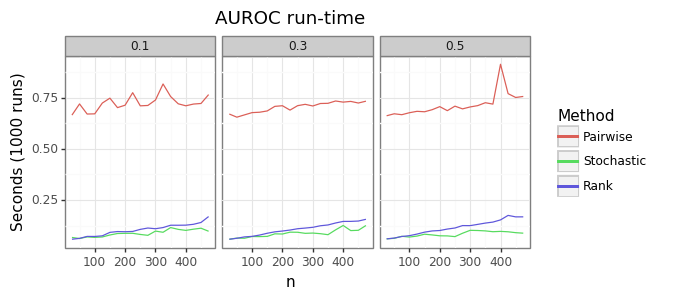

<ggplot: (8786973408545)>

In [190]:
df_rt = pd.concat(holder).melt(['p','n'],None,'method')
plotnine.options.figure_size = (6, 2.5)
gg_ti = (ggplot(df_rt,aes(x='n',y='value',color='method')) + theme_bw() + 
         facet_wrap('~p') + geom_line() + 
         scale_color_discrete(name='Method',labels=['Pairwise','Stochastic','Rank']) + 
         ggtitle('AUROC run-time') + 
         labs(y='Seconds (1000 runs)', x='n'))
gg_ti

In [222]:
# Get the quality of the stochastic approximation
nsim = 100
n_seq = [100, 500, 1000]
c_seq = np.arange(1,11,1).astype(int)

np.random.seed(nsim)
holder = []
for n in n_seq:
    print(n)
    holder_n = []
    for ii in range(nsim):
        y, s = dgp_auc(n, p, 0, dist='normal')
        gt_auc = auc_pair(y, s)
        sim_mat = np.array([[auc_rand(y, s, n*c) for c in c_seq] for x in range(nsim)])
        dat_err = np.std(gt_auc - sim_mat,axis=0)
        holder_n.append(dat_err)
    tmp = pd.DataFrame(np.array(holder_n)).melt(None,None,'c','se').assign(n=n)
    holder.append(tmp)

100
500
1000


In [234]:
df_se = pd.concat(holder).reset_index(None, True)
df_se.c = df_se.c.map(dict(zip(list(range(len(c_seq))),c_seq)))
df_se = df_se.assign(sn=lambda x: pd.Categorical(x.n.astype(str),[str(z) for z in n_seq]))

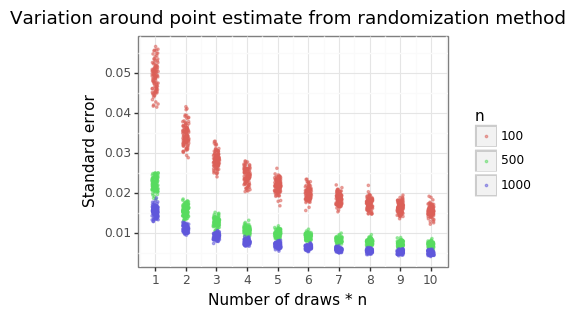

<ggplot: (8786971330301)>

In [238]:
plotnine.options.figure_size = (4, 3)
gg_se = (ggplot(df_se, aes(x='c',y='se',color='sn')) + 
         theme_bw() + labs(y='Standard error',x='Number of draws * n') + 
         geom_jitter(height=0,width=0.1,size=0.5,alpha=0.5) + 
         scale_color_discrete(name='n') + 
         scale_x_continuous(breaks=list(c_seq)) + 
         ggtitle('Variation around point estimate from randomization method'))
gg_se

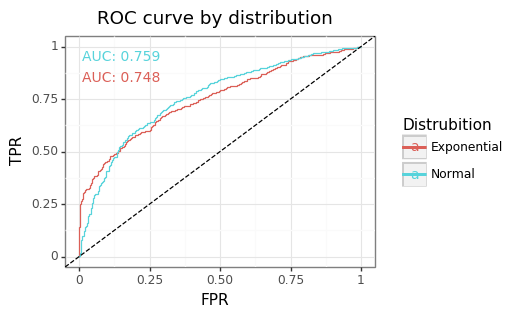

<ggplot: (8786989167857)>

In [133]:
np.random.seed(2)
y_exp, s_exp = dgp_auc(n, p, lam_75, 'exp')
y_norm, s_norm = dgp_auc(n, p, mu_75, 'normal')
fpr_exp, tpr_exp, _ = roc_curve(y_exp, s_exp)
fpr_norm, tpr_norm, _ = roc_curve(y_norm, s_norm)
df = pd.concat([pd.DataFrame({'fpr':fpr,'tpr':tpr,'tt':'Exponential'}),
                pd.DataFrame({'fpr':fpr_norm,'tpr':tpr_norm, 'tt':'Normal'})])
tmp_txt = df.groupby('tt')[['fpr','tpr']].mean().reset_index().assign(fpr=[0.15,0.15],tpr=[0.85,0.95])
tmp_txt = tmp_txt.assign(lbl=['AUC: %0.3f' % auc_rank(y_exp, s_exp),
                    'AUC: %0.3f' % auc_rank(y_norm, s_norm)])

plotnine.options.figure_size = (4, 3)
gg_roc = (ggplot(df,aes(x='fpr',y='tpr',color='tt')) + theme_bw() + 
          geom_step() + labs(x='FPR',y='TPR') + 
          scale_color_discrete(name='Distrubition') + 
          ggtitle('ROC curve by distribution') + 
          geom_abline(slope=1,intercept=0,linetype='--') + 
          geom_text(aes(label='lbl'),size=10,data=tmp_txt))
gg_roc

Figure 1 shows that the baseline runtime for the pairwise method from `sklearn`'s `roc_auc_score` is many of orders of magnitude slower. The stochastic methods begins to show some marginal gains for larger sample sizes.

However Figure 2 shows that the number of samples needed to get a small standard error around the point estimate is not trivial. For example, to get the standard to deviation to within 0.5% (i.e. a ±1% error range),one needs a total of 10x1000=10K sample draws from each class.

Figure 3 shows that even though the AUROC between the two curves is very similar, the exact sensitivity/specificity tradeoff can vary. The Exponential distribution tends to have a more favourable sensitivity for high thresholds because of the right skew of the data.

### Approach #1: Asymptotic U

Under the assumption that $P(s_i^1 > s_i^0) = 0$, it can be shown that:

$$
\begin{align*}
z &= \frac{U - \mu_U}{\sigma_U} \\ 
\mu_U &= \frac{n_1n_2}{2} \\
\sigma^2_U &= \frac{n_1n_2(n_1+n_2+1)}{12}
\end{align*}
$$

There are additional corrections that need to be applied in the case of data which has ties, but I will not cover these continuity corrections here.


### Approach #2: Hanley & McNeil

Formula from [here](https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/PASS/Confidence_Intervals_for_the_Area_Under_an_ROC_Curve.pdf)

$$
\begin{align*}
AUC &\pm z_{\alpha/2} \sigma_{AUC} \\
\sigma^2_{AUC} &= \frac{AUC(1-AUC)+(n_1-1)(q_1-AUC^2)+(n_2-1)(q_2-AUC^2)}{n_1n_2} \\
q_1 &= \frac{AUC}{2-AUC}, \hspace{2mm} q_2 = \frac{2AUC^2}{1+AUC}
\end{align*}
$$


### Approach #3: Bootstrap

BOOSTRAPPING RANKS OR RANKING BOOTSTRAPS?

In [135]:
n, p = 1000, 0.5
target_auc = 0.75
nsim = 1000
mu_75 = np.sqrt(2) * stats.norm.ppf(target_auc)
lam_75 = target_auc / (1 - target_auc)

sim_exp = np.array([auc_rank(*dgp_auc(n, p, lam_75, 'exp')) for x in range(nsim)])
sim_norm = np.array([auc_rank(*dgp_auc(n, p, mu_75, 'normal')) for x in range(nsim)])
print(sim_exp.std()); print(sim_norm.std())

0.015953016921450094
0.014689784786770594
